### Notebook show work of GoogLeNet model

In [1]:
import sys

import numpy as np
import tensorflow as tf
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline

sys.path.append('../..')
from inception import InceptionV1
from dataset.dataset.opensets import MNIST
from dataset import V,B,F

In [2]:
mnist = MNIST()

ExtractingExtracting Extracting /tmp/t10k-images-idx3-ubyte.gz /tmp/train-images-idx3-ubyte.gzExtracting
/tmp/t10k-labels-idx1-ubyte.gz
 /tmp/train-labels-idx1-ubyte.gz



In [3]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1),
                                 'dtype': 'float32',
                                 'data_format': 'channels_last'},
                
                       'labels': {'shape': (10),
                                 'dtype': 'int32',
                                 'data_format': 'channels_last',
                                 'transform': 'ohe',
                                 'name': 'targets'}
}

In [4]:
model_config = {'inputs': placeholders_config,
               'loss':'softmax_cross_entropy',
               'optimizer':'Adam',
               'dim': 2,
               'batch_norm': True,
               'dropout_rate':0.4,
               'head_style': 'dense'}

In [5]:
train_dict = {'images': B('images'),
              'labels': B('labels')}

In [13]:
pipeline = (mnist.train
           .p
           .init_variable('acc', init_on_each_run=list)
           .init_model('dynamic',
                      InceptionV1,
                      'inception_v1',
                      config=model_config)
           .train_model('inception_v1',
                        fetches='accuracy',
                        feed_dict=train_dict,
                        save_to=V('acc'), mode='a'))
pipeline_t = (mnist.test
           .p
           .init_variable('acc', init_on_each_run=list)
           .init_variable('prediction', init_on_each_run=list)
           .init_variable('image', init_on_each_run=list)
           .init_variable('true_value', init_on_each_run=list)
           .import_model('inception_v1', pipeline)
           .predict_model('inception_v1',
                         fetches=['predictions', 'predicted_labels', 'target_labels', 'accuracy'],
                         feed_dict=train_dict,
                         save_to=[V('image'), V('prediction'), V('true_value'), V('acc')], mode='a'))

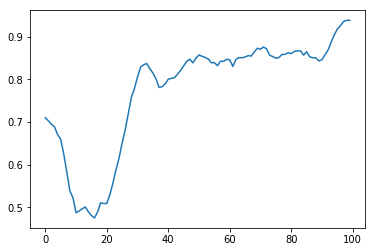

In [15]:
for i in tqn(range(100)):
    pipeline.next_batch(100, n_epochs=None, shuffle=True)
    pipeline_t.next_batch(100, n_epochs=None, shuffle=True)
    if i%10==0:
        clear_output(True)
        plt.plot(ewma(np.array(pipeline_t.get_variable('acc')[-100:]),span=10,adjust=False))
        plt.show()

In [16]:
predict = (mnist.test
          .p
          .init_variable('prediction', init_on_each_run=list)
          .init_variable('image', init_on_each_run=list)
          .init_variable('true_value', init_on_each_run=list)
          .import_model('inception_v1', pipeline)
          .predict_model('inception_v1',
                         fetches=['images', 'predicted_labels', 'target_labels'],
                         feed_dict=train_dict,
                         save_to=[V('image'), V('prediction'), V('true_value')],
                         mode='a'))

In [17]:
for i in tqn(range(100)):
    predict.next_batch(1, n_epochs=None, shuffle=True)

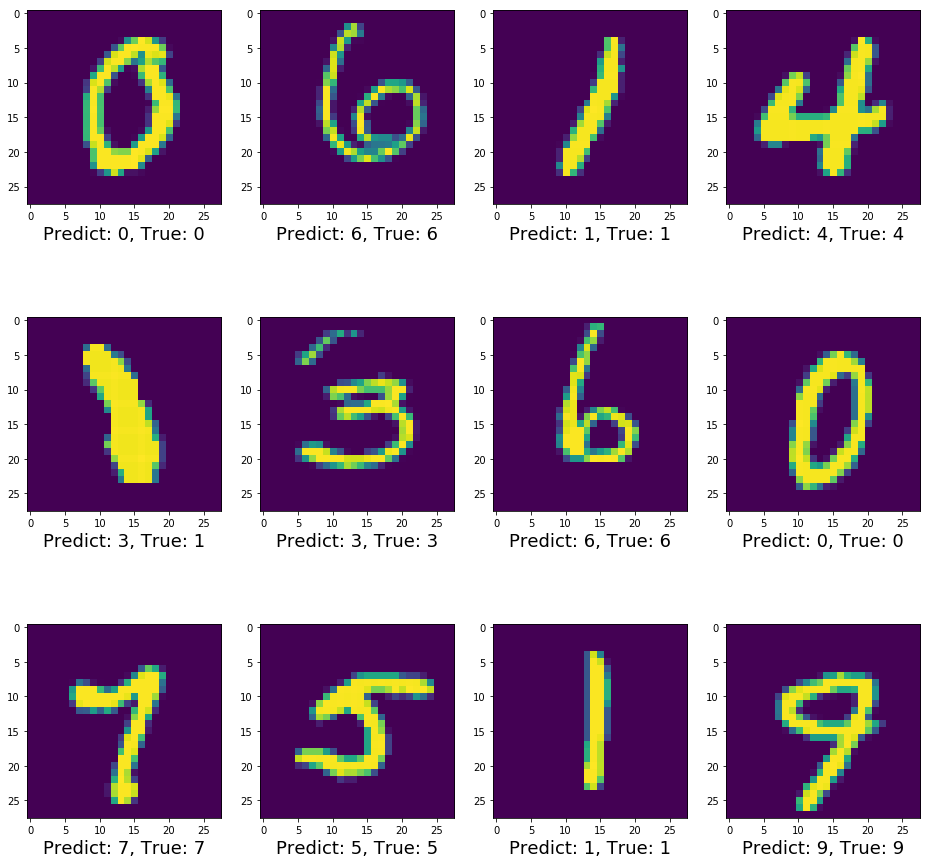

In [18]:
images = predict.get_variable('image')
prediction = predict.get_variable('prediction')
true_value = predict.get_variable('true_value')

_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)
plot = 0
for i in np.random.randint(0, len(true_value), 12):
    ax[plot].imshow(images[i].reshape(-1,28))
    ax[plot].set_xlabel('Predict: {}, True: {}'.format(int(prediction[i][0]), int(true_value[i][0])), fontsize=18)
    plot += 1